Тут попробуем прогнать код для реализации AB-теста

In [91]:
import numpy as np
import pandas as pd
from scipy import stats

alpha = 0.05                    # вероятность ошибки I рода
beta = 0.2                      # вероятность ошибки II рода
mu_control = 2500               # средняя выручка с пользователя в контрольной группе
effect = 100                    # размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 800                       # стандартное отклонение

t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
t_beta = stats.norm.ppf(1-beta, loc=0,scale=1 )
var = 2*std**2
sample_size = int((t_alpha+t_beta)**2*var/(effect ** 2))
print(f'sample_size = {sample_size}')


sample_size = 1004


In [92]:
first_type_errors=[]
second_type_errors=[]

sample_size = 1004
for _ in range(10000):
  control_one = np.random.normal(mu_control, std, sample_size)
  control_two = np.random.normal(mu_control, std, sample_size)
  pilot = np.random.normal(mu_pilot, std, sample_size)
  _, pvalue_aa = stats.ttest_ind(control_one, control_two)
  first_type_errors.append(pvalue_aa < alpha)
  _, pvalue_ab= stats.ttest_ind(control_one, pilot)
  second_type_errors.append(pvalue_ab >= alpha)
part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')



part_first_type_errors = 0.046
part_second_type_errors = 0.207


In [93]:
user_id = np.arange(10000)
control_user_ids, pilot_user_ids = np.random.choice(user_id, (2, sample_size) , replace=False)


In [94]:
def get_stratified_data(strat_to_param, effect=0):
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        control += [
            (x, strat,) for x in np.random.normal(mu, std, n)
        ]
        pilot += [
            (x, strat,) for x in np.random.normal(mu + effect, std, n)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df
def get_random_data(strats, sample, strat_to_param, effect =0):
  control_strats, pilot_strats = np.random.choice(strats, (2, sample_size), False)
  control, pilot =[], []
  for strat, (n, mu, std) in strat_to_param.items():
    n_control_ = np.sum(control_strats == strat)
    control += [(x,strat,) for x in np.random.normal(mu, std, n_control_)]
    n_pilot_ = np.sum(pilot_strats == strat)
    pilot += [(x, strat,) for x in np.random.normal(mu, std, n_pilot_)]
    columns =['value', 'strat']
    control_df=pd.DataFrame(control, columns=columns)
    pilot_df=pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df
def ttest(a: pd.DataFrame, b: pd.DataFrame) -> float:
  _, pvalue = stats.ttest_ind(a['value'].values, b['value'].values)
  return pvalue

In [95]:
alpha = 0.05
N = 10000
w_one, w_two = 0.5, 0.5
N_one = int(N*w_one)
N_two = int(N*w_two)
mu_one, mu_two = 2000, 3000
std_one, std_two = 625, 625
strats = [1 for _ in range(N_one)]+[2 for _ in range(N_two)]

sample_size = 1100
sample_size_one = int(sample_size * w_one)
sample_size_two = int(sample_size * w_two)

In [96]:
strat_to_param = {
    1: (sample_size_one, mu_one, std_one,),
    2: (sample_size_two, mu_two, std_two,)
}

In [97]:
strat_to_param

{1: (550, 2000, 625), 2: (550, 3000, 625)}

In [98]:
random_first_type_errors = []
stratified_first_type_errors = []
random_deltas = []
stratified_deltas = []


In [100]:
for _ in range(10000):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param
    )
    random_deltas.append(
        pilot_random['value'].mean() - control_random['value'].mean()
    )
    stratified_deltas.append(
        pilot_stratified['value'].mean() - control_stratified['value'].mean()
    )

    pvalue_random = ttest(control_random, pilot_random)
    random_first_type_errors.append(pvalue_random < alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_first_type_errors.append(pvalue_stratified < alpha)
part_random_first_type_errors = np.mean(random_first_type_errors)
part_stratified_first_type_errors = np.mean(stratified_first_type_errors)
print(f'part_random_first_type_errors = {part_random_first_type_errors:0.3f}')
print(f'part_stratified_first_type_errors = {part_stratified_first_type_errors:0.3f}')

part_random_first_type_errors = 0.051
part_stratified_first_type_errors = 0.014


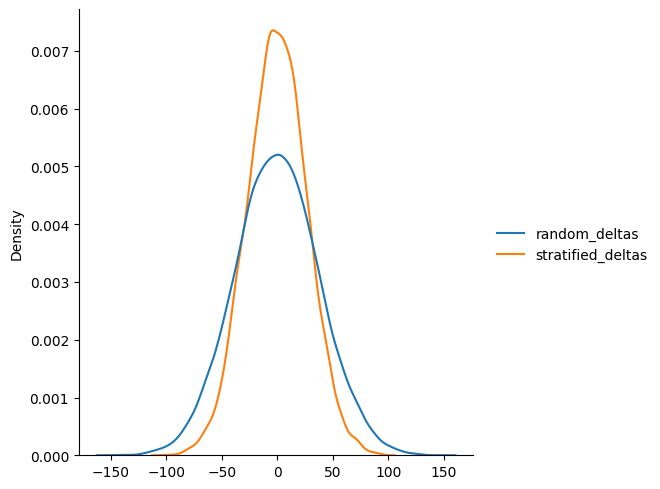

In [102]:
import seaborn as sns

sns.displot(
    {'random_deltas': random_deltas, 'stratified_deltas': stratified_deltas},
    kind='kde'
)

In [ ]:
effect = 100
random_second_type_errors = []
stratified_second_type_errors = []

for _ in range(10000):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param, effect
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param, effect
    )
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)

part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print(f'part_random_second_type_errors = {part_random_second_type_errors:0.3f}')
print(f'part_stratified_second_type_errors = {part_stratified_second_type_errors:0.3f}')

In [103]:
effect = 100
random_second_type_errors = []
stratified_second_type_errors = []

for _ in range(10000):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param, effect
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param, effect
    )
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)

part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print(f'part_random_second_type_errors = {part_random_second_type_errors:0.3f}')
print(f'part_stratified_second_type_errors = {part_stratified_second_type_errors:0.3f}')

part_random_second_type_errors = 0.949
part_stratified_second_type_errors = 0.102


In [104]:
def calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_mean = df.groupby('strat')['value'].mean()
    return (strat_mean * weights).sum()


def calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированную дисперсию.
    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_var = df.groupby('strat')['value'].var()
    return (strat_var * weights).sum()


def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series) -> float:
    """Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    weights - маппинг {название страты: вес страты в популяции}
    """
    a_strat_mean = calc_strat_mean(a, weights)
    b_strat_mean = calc_strat_mean(b, weights)
    a_strat_var = calc_strat_var(a, weights)
    b_strat_var = calc_strat_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue


weights = pd.Series({1: w_one, 2: w_two})

first_type_errors = []
second_type_errors = []

for _ in range(10000):
    control_aa, pilot_aa = get_stratified_data(
        strat_to_param
    )
    control_ab, pilot_ab = get_stratified_data(
        strat_to_param, effect
    )

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')
part_first_type_errors = 0.050
part_second_type_errors = 0.035

part_first_type_errors = 0.046
part_second_type_errors = 0.037


Бутстрэп

In [3]:
import numpy as np

n = 1000
values = np.random.normal(90, 20, n)
mean = values.mean()
std = values.std() / np.sqrt(n)
print(f'Оценка среднего времени доставки: {mean:0.2f}')
print(f'Оценка std для среднего времени доставки: {std:0.2f}')

Оценка среднего времени доставки: 89.21
Оценка std для среднего времени доставки: 0.64


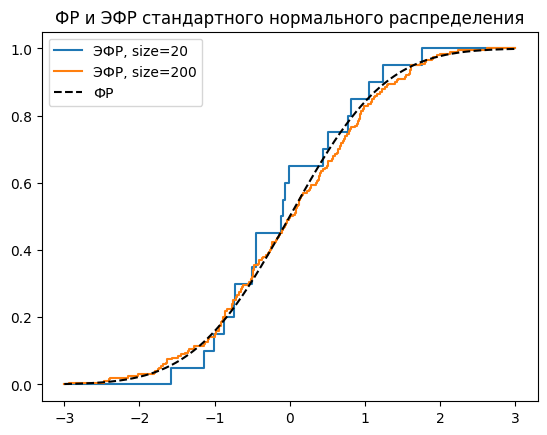

In [6]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
def plot_ecdf(values, label,xlim):
  X_=sorted(set(values))
  Y_=[np.mean(values <= x) for x in X_]
  X = [xlim[0]] + sum([[v, v] for v in X_], []) + [xlim[1]]
  Y= [0, 0 ] + sum([[v, v] for v in Y_], [])
  plt.plot(X, Y, label=label)
for size in [20, 200]:
  values = np.random.normal(size=size)
  plot_ecdf(values, f'ЭФР, size={size}', [-3, 3])

X = np.linspace(-3, 3, 1000)
Y = stats.norm.cdf(X)
plt.plot(X, Y, '--', color = 'k', label = 'ФР')
plt.title('ФР и ЭФР стандартного нормального распределения')
plt.legend()
plt.show()


In [7]:
np.random.choice(values, size=n, replace=True)


array([-0.28921041,  0.5780766 ,  1.19616241,  0.12615578, -1.08998724,
        0.75807289, -0.97808276, -0.10819216,  1.59264484, -0.76365934,
       -0.85508439,  0.93721733,  1.61519401, -0.85508439,  0.10522558,
        0.67315139, -1.13872826, -0.85508439,  0.10522558, -1.7341434 ,
       -0.5541067 ,  1.09078734, -0.64942246, -0.13779194,  0.51249462,
        0.25369389, -0.5541067 ,  0.91203289,  1.29388562, -0.13779194,
       -0.83223512, -2.01819809, -0.49323233,  0.34322214, -0.27925207,
       -1.71799112, -0.91687755, -0.36832877,  0.27830335,  1.60514407,
        0.93721733, -0.36832877, -0.93630012,  0.87390238,  0.62617862,
       -0.7567198 ,  1.59264484,  1.09033899, -0.13029929, -0.86262639,
       -1.0674923 ,  0.93721733,  0.71891219,  0.92843527,  0.60507866,
       -0.97808276,  0.51307906, -0.93630012,  0.99336955,  1.09078734,
       -1.7341434 ,  1.80786938, -0.85508439,  0.34322214,  0.16908863,
        0.22710955,  0.93721733, -0.07049454, -0.70041359, -0.91

In [10]:
n = 1000
B = 1000
values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)
print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 113.22
Оценка std для 90% квантиля: 1.16
113.22321293663192
